In [1]:
import pandas as pd
import scipy as sci
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
from scipy.signal import butter, lfilter
import datetime
from scipy.signal import iirfilter
%matplotlib inline

In [2]:
TP_L = 0
IF_L = 1
IF_R = 2
TP_R = 3
BASELINE = 4
channal_name = []
channal_name.append("TP_L")
channal_name.append("IF_L")
channal_name.append("IF_R")
channal_name.append("TP_R")
channal_name.append("BASELINE")



In [3]:
eegF1_df = pd.read_json('file:eegData_F1.json')
eegF2_df = pd.read_json('file:eegData_F2.json')
eegF3_df = pd.read_json('file:eegData_F3.json')
eegM1_df = pd.read_json('file:eegData_M1.json')
eegM2_df = pd.read_json('file:eegData_M2.json')
eegM3_df = pd.read_json('file:eegData_M3.json')
eegM4_df = pd.read_json('file:eegData_M4.json')
eegM5_df = pd.read_json('file:eegData_M5.json')

eventF1_df = pd.read_json('file:Event_F1.json')
eventF2_df = pd.read_json('file:Event_F2.json')
eventF3_df = pd.read_json('file:Event_F3.json')
eventM1_df = pd.read_json('file:Event_M1.json')
eventM2_df = pd.read_json('file:Event_M2.json')
eventM3_df = pd.read_json('file:Event_M3.json')
eventM4_df = pd.read_json('file:Event_M4.json')
eventM5_df = pd.read_json('file:Event_M5.json')

accelF1_df = pd.read_json('file:accelerometerJson_F1.json')
accelM1_df = pd.read_json('file:accelerometerJson_M1.json')
fs = 256
eventM1_df = eventM1_df[['value', 'timestamp']]
participants_eeg = [eegF2_df, eegF3_df, eegM3_df, eegM4_df,eegM5_df]
participants_event = [eventF2_df,eventF3_df,eventM3_df,eventM4_df,eventM5_df]

In [4]:
for i in participants_event:
    print(i)

    picIndex                  timestamp
0          0 2019-07-30 02:07:48.628125
1          0 2019-07-30 02:07:53.034375
2          4 2019-07-30 02:07:57.487500
3          4 2019-07-30 02:08:01.893750
4          0 2019-07-30 02:08:06.346875
5          0 2019-07-30 02:08:10.753125
6          7 2019-07-30 02:08:15.159375
7          7 2019-07-30 02:08:19.612500
8          1 2019-07-30 02:08:24.018750
9          1 2019-07-30 02:08:28.471875
10        16 2019-07-30 02:08:32.878125
11        16 2019-07-30 02:08:37.284375
12         1 2019-07-30 02:08:41.737500
13         1 2019-07-30 02:08:46.143750
14         4 2019-07-30 02:08:50.596875
15         4 2019-07-30 02:08:55.003125
16         5 2019-07-30 02:08:59.409375
17         5 2019-07-30 02:09:03.862500
18         2 2019-07-30 02:09:08.268750
19         2 2019-07-30 02:09:12.721875
20        16 2019-07-30 02:09:17.128125
21        16 2019-07-30 02:09:21.534375
22         0 2019-07-30 02:09:25.987500
23         0 2019-07-30 02:09:30.393750


In [5]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def notch_filter_60hz(data, fs, band_width=2, freq=60, order=3, filter_type='butter'):
    nyq  = fs/2.0
    low  = freq - band_width/2.0
    high = freq + band_width/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data


def clean_data(data, fs):
#    print(data.shape)
#    print(np.isnan(data).any())
    mean = np.mean(data)
#    print(data.shape,'Mean: ' + str(mean))
#    print(type(mean))
#    print(mean)
    data = data - mean
#    print(data.shape)
#    print(np.isnan(data).any())
#    print(data)
#    data = notch_filter_60hz(data,fs)
    data = butter_bandpass_filter(data, .5, 15, fs)
#    print(data)
#    print(data.shape)
#    print(np.isnan(data).any())
    return data

def discard_first_trial(eventlist):
    eventlist = np.delete(eventlist,0,1)
    return eventlist


In [6]:
def datetime_to_float(d):
    epoch = datetime.datetime.utcfromtimestamp(0)
    total_seconds =  (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds

def compute_EEG_indices(event_timestamps, fs):
    indices = np.array([int(i * fs) for i in event_timestamps]).astype(int)
    return indices

def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

In [7]:
def process_eeg_dataframe(df):
    df_raw_time_vector = df[df['electrode'] == 0]['timestamp'].to_numpy()
    time_spacing = []
    
    for i in np.arange(1,len(df_raw_time_vector)):
        time_spacing.append(df_raw_time_vector[i]-df_raw_time_vector[i-1])

        if(i>1):
            if(not time_spacing[i-1] == time_spacing[i-2]):
                print(time_spacing[i-1],time_spacing[i-2])

    dt_stamp = time_spacing[0]
    dt = dt_stamp / np.timedelta64(1, 's')
    
    T = df_raw_time_vector[-1] - df_raw_time_vector[0] + dt_stamp
    T = T / np.timedelta64(1, 's')

    time_vector = np.arange(0,T,dt/12)
    
    channel_list = []
    eeg_channels = []
    for channel in np.arange(5):
        channel_list.append(df[df['electrode'] == channel])
        eeg_temp = channel_list[channel]['samples'].tolist()
        eeg = []
        for a in eeg_temp:
            for b in a:
                eeg.append(b)
        eeg_channels.append(clean_data(np.array(eeg),fs))
#        print('shape of channel ',channel,': ',eeg_channels[channel].shape)
    eeg_channels = np.array(eeg_channels).squeeze()
    return time_vector,eeg_channels,T

In [8]:
def process_event_dataframe(df,start_time):
    data = df.to_numpy()
    for i in np.arange(len(data)):
        data[i,1] = (datetime_to_float(df["timestamp"][i]) - start_time)
    return data.T

def first_timestamp(df):
    timestamp = df['timestamp'][0]
    return timestamp

In [9]:
def grab_epoch(data, index, fs, len_pre, len_post):
    epoch = np.array([i for i in data[(index+int(len_pre*fs) if index+int(len_pre*fs) >= 0 else 0):index+(len_post*fs)]])
    return epoch

def get_windows(data, indices, fs, len_pre, len_post):
    epoch_list = []
    for index in indices:
        epoch = []
        if index+int(len_pre*fs) < 0 or index+int(len_post*fs) >= len(data): 
            continue
        start = index+int(len_pre*fs) 
        end = index+int(len_post*fs)
        baseline = np.mean(data[start:index])
        for value in data[start:end]:
            epoch.append(value - baseline)
        if(np.var(epoch) > 200):
            continue
        epoch_list.append(epoch)
    return np.array(epoch_list)

In [10]:
time_vector_list = []
eeg_list = []
length_list = []
event_list = []

for i in np.arange(len(participants_eeg)):
#    print(i)
    time_vector,eeg,T = process_eeg_dataframe(participants_eeg[i])
    time_vector_list.append(time_vector)
    eeg_list.append(eeg)
    length_list.append(T)
    event = process_event_dataframe(participants_event[i],datetime_to_float(first_timestamp(participants_eeg[i])))
    event[1] = compute_EEG_indices(event[1], fs)
    event = discard_first_trial(event)
    event_list.append(event)


In [11]:
print(event_list)

[array([[0, 4, 4, 0, 0, 7, 7, 1, 1, 16, 16, 1, 1, 4, 4, 5, 5, 2, 2, 16,
        16, 0, 0, 13, 13, 15, 15, 1, 1, 13, 13, 8, 8, 15, 15, 4, 4],
       [2256, 3396, 4524, 5664, 6792, 7920, 9060, 10188, 11328, 12456,
        13584, 14724, 15852, 16992, 18120, 19248, 20388, 21516, 22656,
        23784, 24912, 26052, 27180, 28320, 29448, 30576, 31716, 32844,
        33984, 35112, 36240, 37380, 38508, 39648, 40776, 41904, 43044]],
      dtype=object), array([[5, 12, 12, 7, 7, 7, 7, 5, 5, 7, 7, 7, 7, 4, 4, 4, 4, 7, 7, 11,
        11, 5, 5, 15, 15, 5, 5, 11, 11, 5, 5, 6, 6, 4, 4, 8, 8],
       [2268, 3396, 4535, 5663, 6804, 7932, 9060, 10200, 11328, 12468,
        13595, 14723, 15864, 16992, 18131, 19259, 20387, 21528, 22656,
        23796, 24924, 26052, 27191, 28319, 29460, 30588, 31716, 32856,
        33984, 35124, 36251, 37379, 38520, 39648, 40787, 41915, 43044]],
      dtype=object), array([[9, 10, 10, 12, 12, 3, 3, 16, 16, 6, 6, 14, 14, 11, 11, 2, 2, 0,
        0, 8, 8, 17, 17, 12, 12, 4, 4

In [12]:
M1_offset = datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))
M2_offset = datetime_to_float(eventM2_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM2_df))
M3_offset = datetime_to_float(eventM3_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM3_df))
M4_offset = datetime_to_float(eventM4_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM4_df))
M5_offset = datetime_to_float(eventM5_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM5_df))
F1_offset = datetime_to_float(eventF1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF1_df))
F2_offset = datetime_to_float(eventF2_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF2_df))
F3_offset = datetime_to_float(eventF3_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF3_df))

print('M1 offset: ' + str(M1_offset))
print('M2 offset: ' + str(M2_offset))
print('M3 offset: ' + str(M3_offset))
print('M4 offset: ' + str(M4_offset))
print('M5 offset: ' + str(M5_offset))
print('F1 offset: ' + str(F1_offset))
print('F2 offset: ' + str(F2_offset))
print('F3 offset: ' + str(F3_offset))

target_offset = (M3_offset + M4_offset)/2

m3_offset_shift = target_offset - M3_offset
m4_offset_shift = target_offset - M4_offset

m3_index_shift = int(fs * m3_offset_shift)
m4_index_shift = int(fs * m4_offset_shift)

print(m3_index_shift)
print(m4_index_shift)

# note: fix indices for M3 and M4

M1 offset: 11.270625114440918
M2 offset: 11.25
M3 offset: -3165.8001251220703
M4 offset: 3174.6126248836517
M5 offset: 4.40625
F1 offset: 611.2706251144409
F2 offset: 4.40625
F3 offset: 4.453125
811572
-811572


In [13]:
print(event_list[2][1])
event_list[2][1] = event_list[2][1] + m3_index_shift
print(event_list[2][1])

[-809316 -808176 -807048 -805908 -804780 -803652 -802512 -801384 -800244
 -799116 -797988 -796848 -795720 -794580 -793452 -792324 -791184 -790056
 -788916 -787788 -786660 -785520 -784392 -783252 -782124 -780996 -779856
 -778728 -777588 -776460 -775332 -774192 -773064 -771924 -770796 -769668
 -768528]
[2256 3396 4524 5664 6792 7920 9060 10188 11328 12456 13584 14724 15852
 16992 18120 19248 20388 21516 22656 23784 24912 26052 27180 28320 29448
 30576 31716 32844 33984 35112 36240 37380 38508 39648 40776 41904 43044]


In [14]:
print(event_list[3][1])
event_list[3][1] = event_list[3][1] + m4_index_shift
print(event_list[3][1])

[813828 814968 816096 817224 818364 819492 820632 821760 822888 824028
 825156 826296 827424 828552 829692 830820 831960 833088 834216 835356
 836484 837624 838752 839880 841020 842148 843288 844416 845544 846684
 847812 848952 850080 851208 852348 853476 854616]
[2256 3396 4524 5652 6792 7920 9060 10188 11316 12456 13584 14724 15852
 16980 18120 19248 20388 21516 22644 23784 24912 26052 27180 28308 29448
 30576 31716 32844 33972 35112 36240 37380 38508 39636 40776 41904 43044]


In [23]:
len_pre = -1
len_post = 2

In [24]:
cat_index = []
snake_index = []

for i in np.arange(len(eeg_list)):
    cat_index.append([])
    snake_index.append([])            

epochs_cat = [[],[],[],[],[]]
epochs_snake = [[],[],[],[],[]]


for participant in np.arange(len(eeg_list)):
    for i in np.arange(len(event_list[participant][0])):
#        print(participant,i)
        if(event_list[participant][0][i] < 12):
            cat_index[participant].append(event_list[participant][1][i])
        else:
            snake_index[participant].append(event_list[participant][1][i])



for participant in np.arange(len(eeg_list)):
    for channel in np.arange(5):
        cat_windows = np.array(get_windows(eeg_list[participant][channel], cat_index[participant], fs, len_pre, len_post))
        cat_windows = cat_windows / np.mean(np.abs(cat_windows))
        snake_windows = np.array(get_windows(eeg_list[participant][channel], snake_index[participant], fs, len_pre, len_post))
        snake_windows = snake_windows / np.mean(np.abs(snake_windows))
        for epoch in cat_windows:
            epochs_cat[channel].append(epoch)
        for epoch in snake_windows:
            epochs_snake[channel].append(epoch)    
        
epochs_cat = np.array(epochs_cat)

epochs_snake = np.array(epochs_snake)


In [25]:
epochs_cat.shape

(5,)

In [26]:
for channel in np.arange(5):
    for participant in np.arange(len(eeg_list)):
        cat_windows = np.array(get_windows(eeg_list[participant][channel], cat_index[participant], fs, len_pre, len_post))
        cat_windows = cat_windows / np.mean(np.abs(cat_windows))
        snake_windows = np.array(get_windows(eeg_list[participant][channel], snake_index[participant], fs, len_pre, len_post))
        snake_windows = snake_windows / np.mean(np.abs(snake_windows))
        for epoch in cat_windows:
            epochs_cat[channel].append(epoch)
        for epoch in snake_windows:
            epochs_snake[channel].append(epoch)    

In [27]:
#cat_index[participant]


    

In [28]:
#cat_index
#snake_index
#epochs_cat
#epochs_snake
print(np.array(epochs_cat[0]).shape)
print(np.array(epochs_snake[0]).shape)
print(np.mean(epochs_cat[0]))


(112, 768)
(48, 768)
0.011983497324986915


In [29]:

cat_average = []
snake_average = []
for channel in np.arange(5):
#    print(np.array(epochs_cat[channel]).shape)
    cat_average.append(np.mean(epochs_cat[channel], axis=0))
    snake_average.append(np.mean(epochs_snake[channel], axis=0))

cat_average= np.array(cat_average)
snake_average= np.array(snake_average)

epoch_time = np.arange(len_pre, len_post, 1/fs)

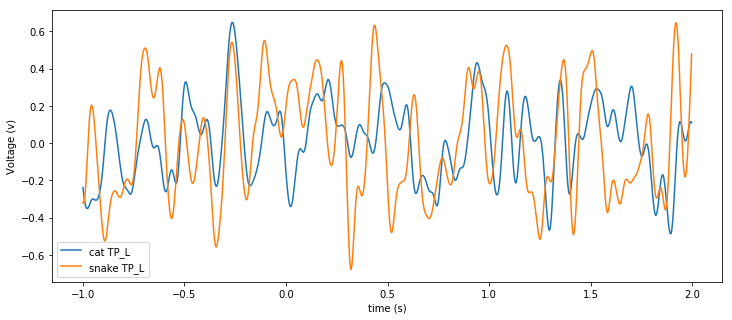

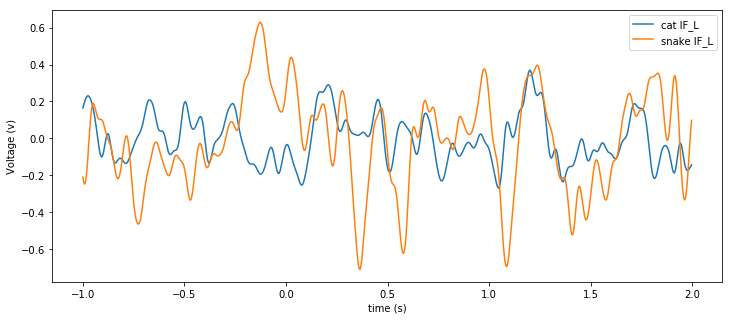

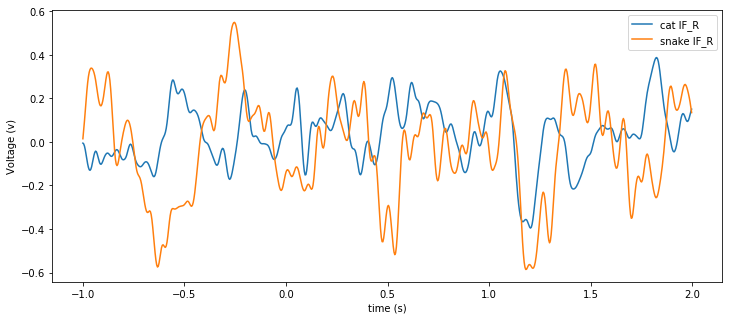

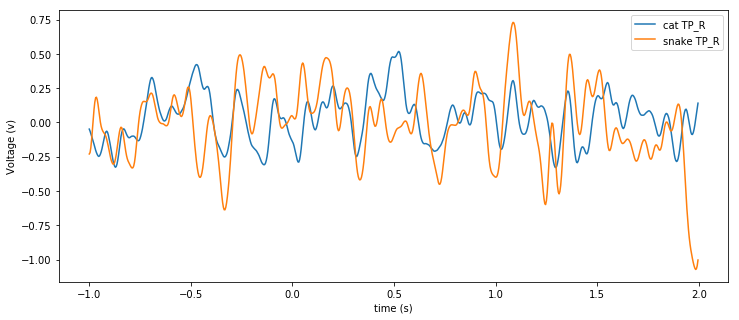

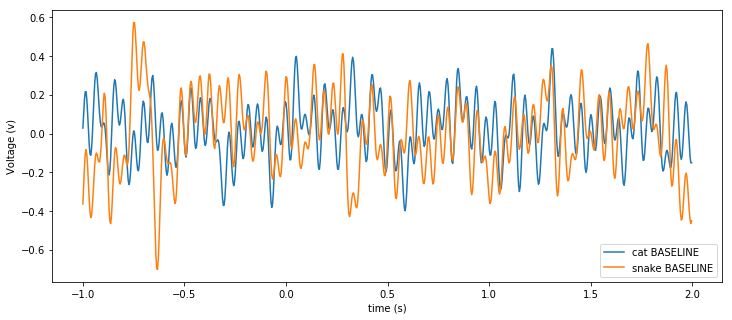

In [30]:
for i in range(0,len(channal_name)):
    # plot STA
    plt.figure(figsize=(12,5))
    plt.plot(epoch_time, cat_average[i], '-', label = "cat " + channal_name[i])
    plt.plot(epoch_time, snake_average[i], '-', label = "snake " + channal_name[i])
    plt.xlabel('time (s)'); plt.ylabel('Voltage (v)');
    plt.legend()
